**Authors:**

- Ravi Teja Kothuru (Primary)
- Soumi Ray
- Anwesha Sarangi

**Title of the Project:** SmartChat: A Context-Aware Conversational Agent

**Description of the Project:** Develop a chatbot that can effectively adapt to context and topic shifts in a conversation, leveraging the Stanford Question Answering Dataset to provide informed and relevant responses, and thereby increasing user satisfaction and engagement.

**Objectives of the Project:** Create a user-friendly web or app interface that enables users to have natural and coherent conversations with the chatbot, with high satisfaction rating.

**Name of the Dataset:** Stanford Question Answering Dataset

**Description of the Dataset:** The Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset consisting of questions posed by crowdworkers on a set of Wikipedia articles. The answer to every question is a segment of text, or span, from the corresponding reading passage. There are 100,000+ question-answer pairs on 500+ articles. More information can be found at: https://rajpurkar.github.io/SQuAD-explorer/

**Dataset Source:**

Kaggle (https://www.kaggle.com/datasets/stanfordu/stanford-question-answering-dataset)

***Number of Variables in Dataset:*** There are 2 variables in this dataset

- data
- version

Each of these have other variables such as:

- ***context:*** A lengthy paragraph that has some information.
- ***question:*** A question based on the context.
- ***answer:*** An answer to the context from the context.
- ***ans_start:*** The index value of context where the answer to the question is started.
- ***ans_end:*** The index value of context where the answer to the question is ended.

***Size of the Dataset:*** The dataset has 2 JSON files. One is for training and the other is for validation

- Training Dataset's filename is train-v1.1.json and it size is 30.3 MB.
- Validation Dataset's filename is dev-v1.1.json and it size is 4.9 MB.

# Install/Import all the necessary libraries

In [1]:
!pip install datasets torch peft transformers evaluate safetensors rouge-score nltk rouge seaborn matplotlib
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from safetensors.torch import load_model, save_model
from datasets import load_dataset
import evaluate
from peft import PeftModel, PeftConfig
import os
import rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

Error in cpuinfo: prctl(PR_SVE_GET_VL) failed


# Load the GPT2-Medium Tokenizer

- **Set Padding Token:** The code assigns a special symbol to represent empty spaces or padding in the text. This symbol helps the model understand when there is no actual content.

- **Assign Padding Token ID:** The code also sets an identifier for the padding symbol. This identifier is a number that the model uses to recognize the padding symbol in the processed text.

In [2]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "openai-community/gpt2-medium"
)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Verify the existence of CPU/GPU and confirm what is being used

In [3]:
# Check if GPU is available. If yes, use it. Else, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using the device: {device}")

Currently using the device: cpu


# Load SQuAD dataset from HuggingFace datasets library and capture only the Validation part of it

- Please be informed - this SQuAD (Stanford Question Answering) dataset is available in HuggingFace's datasets library itself. Hence, there is no need of downloading the dataset files to the local and loading them.

- Since we are working on SQuAD v1.1, squad should be sufficient. The `load_dataset` function from datasets library helps in loading the required dataset.

- As there are more than 10000 records we initially loaded only the first 5 records of the validation dataset.

In [4]:
dataset = load_dataset("squad")
validation_ds = dataset['validation'].select(range(5))
validation_ds

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5
})

# Function to format the input prompt and tokenize it

- `prompts` list contains formatted strings for each question and its corresponding context.
- For each pair of question (`q`) and context (`c`) in `examples`, the function creates a string that starts with `"Context: "`, followed by the context text, then `"Question: "`, followed by the question text, and finally ends with `"<|start_answer|>"`.
- After creating the list of formatted strings, the `tokenizer` function is called. This function converts the list of prompts into numerical representations that the model can understand.

**Parameters of Tokenization**:
   - `padding="max_length"`: This ensures that all the tokenized prompts are padded to the maximum length specified by `max_length`.
   - `truncation=True`: This allows any prompts that exceed the `max_length` to be shortened.
   - `max_length=256`: This sets the maximum length for each tokenized prompt to 256 tokens.
   - `return_tensors='pt'`: This specifies that the output should be returned as PyTorch tensors, which can be used for model input.

- Finally, the function returns the tokenized prompts, which are now in a format suitable for input into a model.

Look at the following code for the same.

In [5]:
# define format prompt function
def format_prompts(examples):
    prompts = [f"Context: {c}\nQuestion: {q}\n <|start_answer|> Answer:" for q, c in zip(examples['question'], examples['context'])]
    return tokenizer(prompts, padding="max_length", truncation=True, max_length=1000, return_tensors='pt')

- The function named `extract_answer`, which takes one parameter called `generated_text`. This parameter is expected to be a string containing some text.
- `start_token` is defined with the value `"<|start_answer|>"`. This token is used to identify where the actual answer starts in the generated text.
- The function searches for the `start_token` in the `generated_text` and finds its position using the `find` method. 
- It then adds the length of `start_token` to this position to determine the starting index (`start_idx`) of the actual answer text.
- The code checks if `start_idx` is not equal to -1, which means the `start_token` was found in the text. 
- If the token is found, it extracts the answer text starting from `start_idx` and removes any leading or trailing whitespace using the `strip` method.

**Purpose**:
- The main purpose of this function is to isolate and return the answer portion of the `generated_text`, which is located after a specific start token.

In [10]:
def extract_answer(generated_text):
    start_token = "<|start_answer|>"
    
    # Extract the text between the special tokens
    start_idx = generated_text.find(start_token) + len(start_token)
    
    if start_idx != -1:
        generated_text = generated_text[start_idx:].strip()
    
    question_index = generated_text.find("Question:")

    if question_index != -1:
        generated_text = generated_text[0:question_index].strip()
    
    return generated_text

## Load the fine-tuned and trained gpt2-medium-lora model

- As there are more than 10000 records in the validation dataset, the Jupyter notebook cannot handle printing all those records.
- Hence, I have printed only 5 records of the validation dataset to make you better understand.
- Detailed prediction will be demonstrated using the Chatbot UI.

In [11]:
# load fine-tuning model
from peft import AutoPeftModelForCausalLM
ft_model = AutoPeftModelForCausalLM.from_pretrained("gpt2-medium-lora")
# ft_model.to(device)

inputs = format_prompts(validation_ds)
outputs = ft_model.generate(**inputs, do_sample=False, max_new_tokens=32, top_k=60, top_p=0.95, temperature=0.5, num_return_sequences=1)
# generate anwsers
generated_answers = [extract_answer(tokenizer.decode(output, skip_special_tokens=True)) for output in outputs]

# display result
for input, output, ans in zip(inputs['input_ids'], outputs, generated_answers):
    print("\n-------compare--------")
    print(f"\ninput:\n{tokenizer.decode(input, skip_special_tokens=True)}")
    print(f"\nanswer:\n{ans}")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



-------compare--------

input:
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question: Which NFL team represented the AFC at Super Bowl 50?
 <|start_answer|> Answer:

answer:
Answer:The Denver Broncos

-------compare--------

input:
Context: Super Bowl 50 was 

# Evaluation Metrics for Natural Language Processing Tasks

## Overview of Common Metrics

Note that these are commonly used metrics to evaluate the performance of NLP models:

- **ROUGE score:** This requires a library like rouge-score.

- **BLEU score:** This requires a library like nltk.

**Important Note:** I have predicted the answers of the validation dataset only for the first 5 rows considering computational resource constraints. I have demonstrated the predictions via chatbot UI in detail.

In [12]:
nltk.download('punkt_tab')

rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []
bleu_scores = []

# display result
# for input, output, ans, reference in zip(inputs['input_ids'], outputs, generated_answers, validation_ds['answers']['text']):
for input, output, ans, reference in zip(inputs['input_ids'], outputs, generated_answers, [answer['text'] for answer in validation_ds['answers']]):

    reference = reference[0]
    
    # Calculate ROUGE score
    rouge_scores = rouge.Rouge()
    scores = rouge_scores.get_scores(ans, reference)
    rouge_1_scores.append(scores[0]['rouge-1']['f'])
    rouge_2_scores.append(scores[0]['rouge-2']['f'])
    rouge_l_scores.append(scores[0]['rouge-l']['f'])

    # Calculate BLEU score
    reference_tokens = word_tokenize(reference)
    answer_tokens = word_tokenize(ans)
    bleu_score = sentence_bleu([reference_tokens], answer_tokens)
    bleu_scores.append(bleu_score)

# Calculate average scores
avg_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
avg_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

print("\nAverage scores for all answers:")
print(f"ROUGE-1: {avg_rouge_1}")
print(f"ROUGE-2: {avg_rouge_2}")
print(f"ROUGE-L: {avg_rouge_l}")
print(f"BLEU: {avg_bleu}")

[nltk_data] Downloading package punkt_tab to /home/ravi/nltk_data...



Average scores for all answers:
ROUGE-1: 0.29952152891804407
ROUGE-2: 0.19516908067530164
ROUGE-L: 0.29952152891804407
BLEU: 0.02162601067591834


[nltk_data]   Package punkt_tab is already up-to-date!
/home/ravi/Documents/my_projects/chatbot-using-gpt2-medium/jupyter_env/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ravi/Documents/my_projects/chatbot-using-gpt2-medium/jupyter_env/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ravi/Documents/my_projects/chatbot-using-gpt2-medium/jupyter_env/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hyp

# Data Visulaizations for this approach

## Actual Answers

### This is just the display of how the actual answers are in the validation dataset

In [26]:
original_answers = [answer['text'] for answer in validation_ds['answers']]
original_answers

[['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers'],
 ['Santa Clara, California',
  "Levi's Stadium",
  "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
 ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['gold', 'gold', 'gold']]

## Predicted Answers

### This is just the display of how the answers are predicted

In [25]:
generated_answers

['Answer:The Denver Broncos',
 'Answer:The New England Patriots (NFC)',
 "Answer:The game was played at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California.",
 'Answer:The Denver Broncos (4-0) won the Super Bowl 50 championship game over the Carolina Panthers (2-2) in the NFC Championship Game. The Broncos',
 'Answer:The color of the gold-colored helmet was gold. The color of the gold-colored helmet was gold.']

## Plot-1: Visualize the Evaluation Metrics post prediction

This barplot depicts the values of bleu score, rouge-1, rouge-2 and rougel scores.

/tmp/ipykernel_5528/3721876537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=labels, y=scores, palette=['blue', 'green', 'red', 'yellow'])


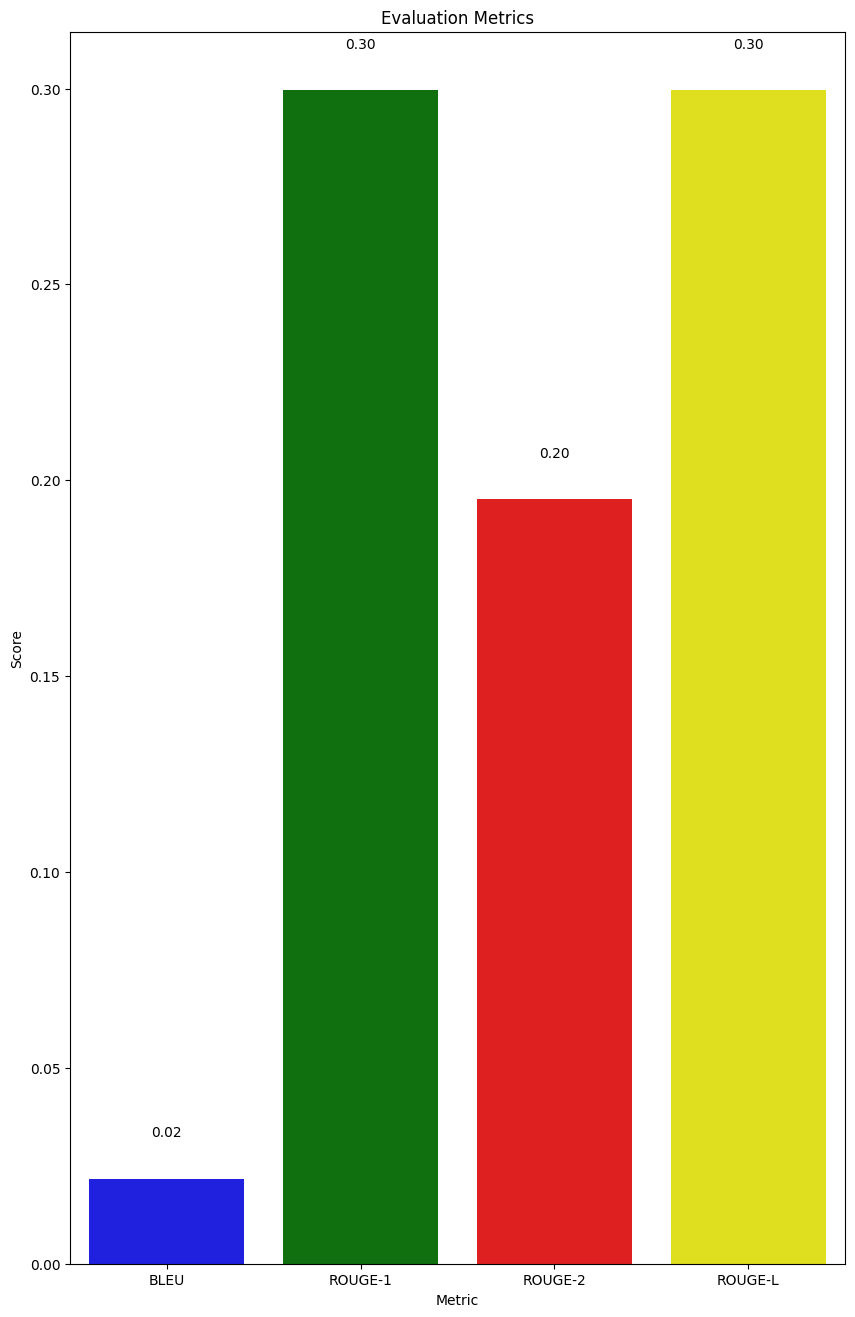

In [14]:
# Scores and labels
scores = [avg_bleu, avg_rouge_1, avg_rouge_2, avg_rouge_l]
labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Plot for BLEU score, ROUGE-1, ROUGE-2 and ROUGE-L score
plt.figure(figsize=(10, 16))
bar_plot = sns.barplot(x=labels, y=scores, palette=['blue', 'green', 'red', 'yellow'])

# Adding scores on top of each bar
for index, value in enumerate(scores):
    bar_plot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()

## Plot-2: Answers vs Predicted Answers

This plot depicts that all the 10570 answers from the validation dataset are predicted.

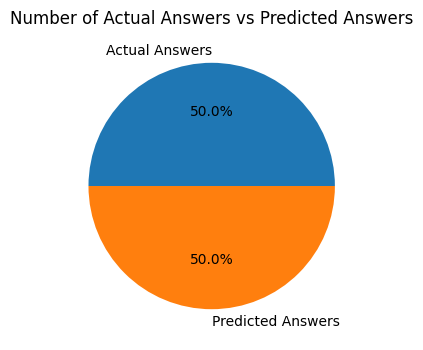

In [20]:
# Calculate the number of actual answers and predicted answers
actual_ans = [answer['text'][0] for answer in validation_ds['answers']]
actual_answers = len(actual_ans)
predicted_answers = len(generated_answers)

# Create a pie chart for the number of actual answers vs predicted answers
plt.figure(figsize=(4, 4))
plt.pie([actual_answers, predicted_answers], labels=['Actual Answers', 'Predicted Answers'], autopct='%1.1f%%')
plt.title('Number of Actual Answers vs Predicted Answers')
plt.show()

## Plot-3: Distribution of Answer lengths

This plot depicts the frequency distribution of answer lengths of Actual answers from validation dataset as well as Predicted answers.

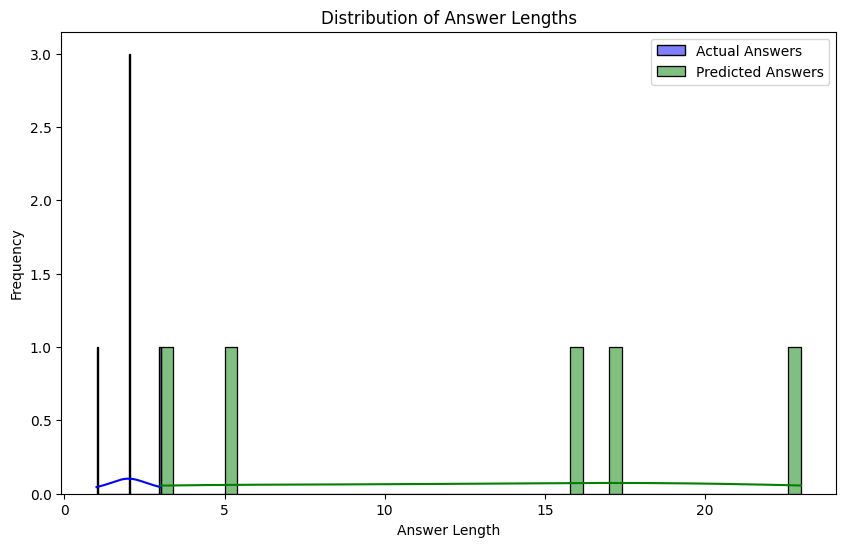

In [24]:
# Calculate the lengths of actual answers and predicted answers
actual_answer_lengths = [len(answer.split()) for answer in actual_ans]
predicted_answer_lengths = [len(answer.split()) for answer in generated_answers]

# Create a distribution plot for the lengths of actual answers and predicted answers
plt.figure(figsize=(10, 6))
sns.histplot(actual_answer_lengths, bins=50, kde=True, color='blue', label='Actual Answers')
sns.histplot(predicted_answer_lengths, bins=50, kde=True, color='green', label='Predicted Answers')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Final Interpretations

## Overall Observations from this approach:**

### Strengths:

- As the requirement is to build the chatbot, we have to generate the text based answers for the context and question passed in. Considering the text generation point of view, ofcourse GPT stands out compared with BERT.
- Based on the strength of the text generation, we considered GPT2-Medium which has 355M parameters, a transformer-based language model. This is a pretrained model in English language using a causal language modeling (CLM) objective.
- We have directly applied tokenization to the text data.
- We used LoRA technique because it adapts pre-trained models by introducing Low Rank Matrices and allow for efficient model tuning.
This way, the number of params can also be reduced. Basically, it helps in improving performance with few resources.
- And at the same time, we used PEFT because this framework helps in fine-tuning models with minimal params and computational resources can also be reduced.
- Though we don't have sufficient computational resources, we were somehow able to achieve atleast these results because of using LoRA and PEFT techniques.
- This model is running into issues/errors while executing in MacBooks. Hence, as a workaround, I trained and predicted this in an Ubuntu machine. We installed it as a virtual machine within the MacBook.
- If you think in general text generation point of view, I have observed that this model has generated good amount of text by learning the context properly etc. etc.
- Please be informed that usually such type of Question-Answering datasets does not qualify for a conversational chatbot that supports multi-turn conversations. But still, we had included the context-management as well as handling variety of topics. Let me explain them below.
    - ***Context Management***: We trained this model in such a way that if you just set the context once and ask multiple questions one after the other, it will definitely answer your questions based on that context. If at all you wish to change the context, just change it and ask the questions accordingly.
    - ***Handling Variety of topics***: Ofcourse we have handled this. Though we trained this using SQuAD dataset alone, even though you provide some random context from the internet and ask questions based on it, it will definitely answer your query.
- We have splitted the train data alone into train and test for training. We made use of only the first 5 rows of the validation dataset to validate the trained model.
- The trained GPT2-Medium model actually predicted more information than the required information. For example: let's says there is a question Where does the Sun rise?. The usual answer is **`East`**. But it predicted as **`The Sun rises in the East`**.
- Let us take a look at the performance metrics scores of this model post predictions.
    - ***ROUGE-1 (0.2995)***: Assesses the similarity of individual words (unigrams) in the produced text and the reference. A score of 0.2995 implies that approximately 29.95% of the individual words in the reference text are present in the generated output.

    - ***ROUGE-2 (0.1952)***: Assesses the similarity of adjacent word pairs. A 0.1952 score means approximately 19.52% of the bigrams from the reference are found in the generated output.

    - ***ROUGE-L (0.2995)***: Takes into account the longest common subsequence (LCS) between the produced output and the reference. The score indicates that approximately 29.95% of the reference's content is accounted for by the longest matching sequences.

    Overall observation for ROUGE score is: the ROUGE scores indicate a moderate level of similarity between the generated responses and the reference answers, with better matching at the unigram level than at the bigram level.

    - BLEU evaluates the accuracy of n-gram matching between the produced text and the reference. An overlap rate of 0.0216 (equivalent to around 2.16%) signifies a minimal similarity, indicating a substantial deviation in the generated responses compared to the reference answers in terms of exact n-gram matches.

    - Because, if you see, for example: the actual answers in validation dataset have `['Denver Broncos', 'Denver Broncos', 'Denver Broncos']` where as the predicted answer looks like `The Denver Broncos`. This example might seem so small. But there are few rows in the validation dataset where the answers are bit lengthy and each index of the answer list have different words. Due to such reasons, along with using only the first 5 rows to predict, the ROUGE and BLEU scores were very low.

### Pain points noticed and the tasks that were not performed:

- The SQuAD dataset whatever we trained using the base GPT2-Medium model ***works very well in Linux/Ubuntu and Windows*** machines. But unfortunately, it does not work in ***MacBooks***. Due to time constraints, we could not spend on figuring out the issue behind not working in MacBook alone.
- Due to the single directional context understanding, GPT2-medium model does not have good understanding of the the text patterns from SQuAD dataset, even though it is trained with millions of parameters.
- We lost the accuracy and the answers that were being predicted, are not as expected as mentioned in the validation dataset.
- We usually have `ans_start` and `ans_end` variables in the train set. We trained data on GPT2-Medium model without passing. This could also be one of the reasons, but it is not the main reason. And due to the text generation nature of GPT2-Medium model, we are unable to achieve as expected because the pattern provided in the validation dataset was completely unique and it has very very small amount of tokens in its `answer` column.
- Due to computational resource and time constraints, we performed only the following items in minimal amount:
    1. I could train only 3 epochs with sleepless nights with a low level GPU.
    2. We validated the trained model using only the first 5 rows because, the trained model is not working in my MacBook. Hence, I installed an Ubuntu machine using virtual box in my Mac and that resource has so very minimum configuration. It consumed half of my MacBook configurations. One question took a minimum of 2 minutes to print its prediction.
    3. As we validated only for the first 5 rows of the validation dataset, we had plotted the above visualizations for those 5 rows alone.
    4. We achieved very less ROUGE and BLEU scores for validating only on the first rows, especially because of the computational constraints. Total reason is explained in the last point of the above section.
    5. We are unable to provide more tweaking and training to the GPT2-Medium model.
    6. We are unable to achieve multi-turn conversations feature because.

### Future Improvement Suggestions:

- The dataset used here is SQuAD, which is nothing but the Question-Answering datasets. In general point of view such datasets qualify for Q&A chatbots but not for conversational chatbots. I definitely wish to research on the multi-turn conversational part as well.
- Try to train the model by passing `ans_start` and `ans_end` variables as well into the training module using GPT2-Medium model as well.
- Investigate ***why this model is not working in MacBook and why only on Linux/Ubuntu and Windows machines?***.
- Try obtaining some high computational power so that the validation can be perfectly done.

# Business Use-cases of this chatbot

Chatbots can be used in real-world at many places. Few use-cases would be:

- 24*7 customer support to handle customer queries and guide in resolving the issues.
- Automation of FAQs in any field.
- Users can check the status of their eCommerce orders and get notified about shipping updates.
- Users can get their banking informatione easily.
- Help students with basic educational information.
- Book online health consultations.
- Chatbots can help astronauts and ground control by offering rapid access to mission information, schedules, and problem-solving guidelines. For example, they are able to access data on spacecraft systems or conduct simple calculations for navigation purposes.
- Chatbots are utilized in streaming platforms to suggest songs, albums, or artists by considering user preferences and listening history. Additionally, they have the ability to recommend playlists tailored to certain emotions, tasks, or music styles.
- Chatbots have the ability to communicate with robots in order to assist operators in managing or overseeing robotic systems. As an illustration, they are able to give status updates, manage motion, or carry out instructions in manufacturing industrial robots.